# Spacetime Indicatrix

In [2]:
#JAX
import jax.numpy as jnp
import jax.random as jran
from jax import vmap
from jax import random as jran


#Scipy
from scipy.ndimage.filters import gaussian_filter

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

#celluloid
from celluloid import Camera # getting the camera

#IPython.display
from IPython.display import HTML # to show the animation in Jupyter

#jaxgeometry
from jaxgeometry.manifolds import LorentzSpacetime
from jaxgeometry.setup import dts

/tmp/ipykernel_162191/2628719075.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## Define File Paths

In [3]:
figure_path = 'Figures/conformal_rl/'

## Defining Manifold

In [11]:
mua_fun = lambda t,x: (1+t+x[0]**2+x[1]**2)*0.5/(2*(1+t)**2)
mub_fun = lambda t,x: (1+t+x[0]**2+x[1]**2)*0.5/(2*(1+t)**2)
mutheta_fun = lambda t,x: jnp.zeros(1, dtype=jnp.float32)

sigmaa_fun = lambda t,x: 1-jnp.exp(-(x[0]+x[1]+t)**4)
sigmab_fun = lambda t,x: 1-jnp.exp(-(x[0]+x[1]+t)**4)
sigmatheta_fun = lambda t,x: jnp.zeros(1, dtype=jnp.float32)

In [12]:
def G(x, eps=jnp.zeros(3)):
    
    theta = mutheta_fun(x[0][0], x[0][1:])+eps[0]*sigmatheta_fun(x[0][0], x[0][1:])
    a2 = (mua_fun(x[0][0], x[0][1:])+eps[1]*sigmaa_fun(x[0][0], x[0][1:]))**2
    b2 = (mub_fun(x[0][0], x[0][1:])+eps[2]*sigmab_fun(x[0][0], x[0][1:]))**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)

    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]]).squeeze()/(a2*b2)

In [13]:
t = 0.5
M = LorentzSpacetime(N=2,
                    g=G)

using M.Exp for Logarithm


## Defining grid

In [14]:
N_grid = 100
start = -2.0
end = 2.0

t_grid = jnp.linspace(0,1,N_grid)
x1_grid = jnp.linspace(start,end,N_grid)
x2_grid = jnp.linspace(start,end,N_grid)
X1_grid, X2_grid = jnp.meshgrid(x1_grid,x2_grid)
X_grid = jnp.concatenate((X1_grid.reshape(N_grid, N_grid, 1), 
                          X2_grid.reshape(N_grid, N_grid, 1)), axis=-1)


N_plot = 10
t_plot = jnp.linspace(0,1,N_plot)
x1_plot = jnp.linspace(start,end,N_plot)
x2_plot = jnp.linspace(start,end,N_plot)
X1_plot, X2_plot = jnp.meshgrid(x1_plot,x2_plot)
X_plot = jnp.concatenate((X1_plot.reshape(N_plot, N_plot, 1), 
                          X2_plot.reshape(N_plot, N_plot, 1)), axis=-1)

### Computing the Metric

In [15]:
def volume_measure(t, x):
    
    M = LorentzSpacetime(N=2,
                    g=G)
    
    return jnp.sqrt(jnp.linalg.det(M.g((jnp.hstack((t,x)), jnp.zeros(1)))))

using M.Exp for Logarithm


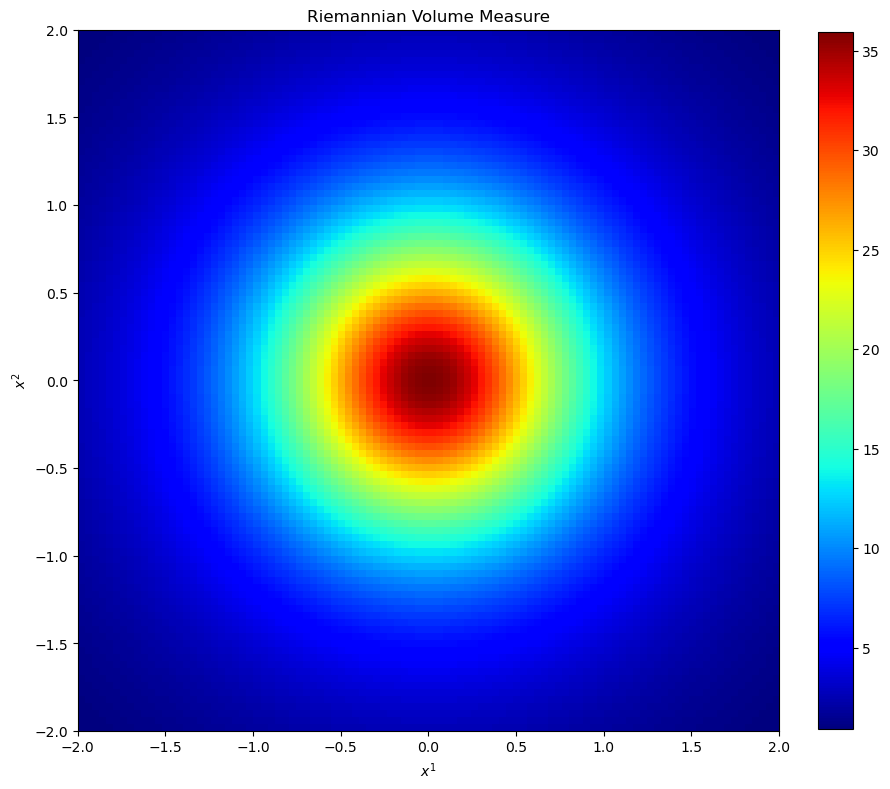

In [18]:
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
#heatmap = sec[:,50,:]
g = vmap(lambda y: vmap(lambda x: volume_measure(0.5,x))(y))(X_grid)
extent = [start, end, start, end]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(g.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([start, end])
ax.set_ylim([start, end])
ax.set_title("Riemannian Volume Measure")
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(g)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()
fig.savefig(figure_path+'rm_volume.pdf', format="pdf", bbox_inches="tight")

### IVP Geodesics

In [ ]:
dt = dts(n_steps=100)

N_spray = 100
p0 = (jnp.zeros(2)+0.2, jnp.zeros(1))
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.cos(phi), jnp.sin(phi)]).T
v = v.T/vmap(lambda w: jnp.sqrt(w.dot(M.g(p0)).dot(w)))(v)
v = jnp.hstack((v))

time_grid, gamma, gamma_chart = vmap(lambda v: M.geodesic(p0, v, dt))(v.T)

using M.Exp for Logarithm


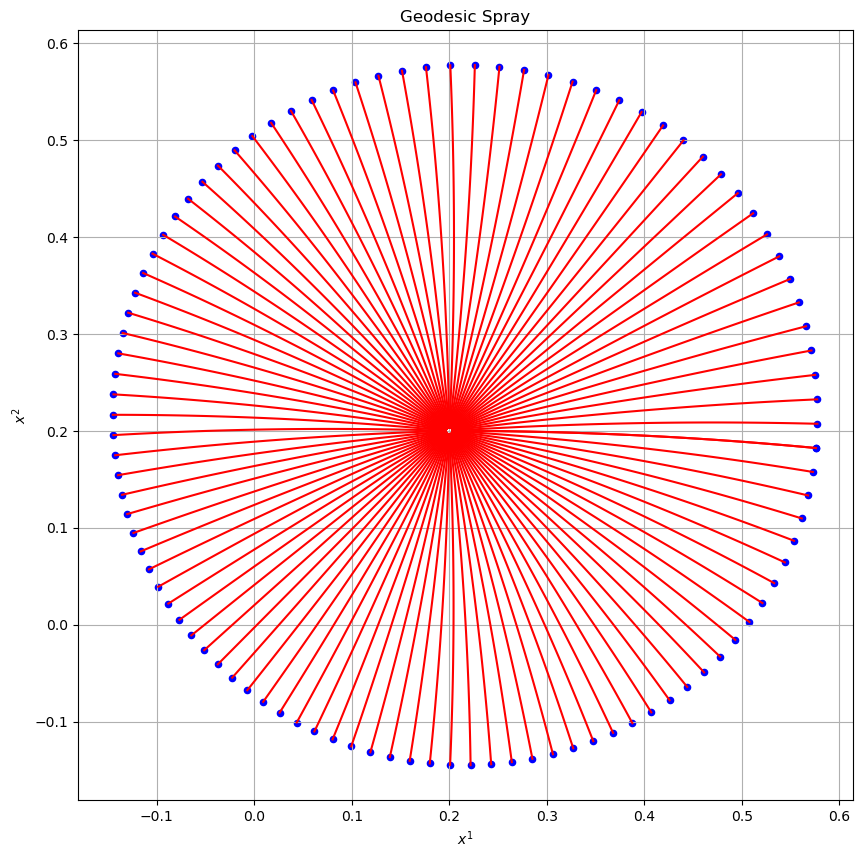

In [41]:
time_grid, rm_gamma, gamma_chart, gamma_v = M_geodesic(0.5)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rm_gamma[:,:,0].T, rm_gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Geodesic Spray")
ax.scatter(rm_gamma[:,-1,0], rm_gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig(figure_path+'rm_ivp2d.pdf', format="pdf", bbox_inches="tight")

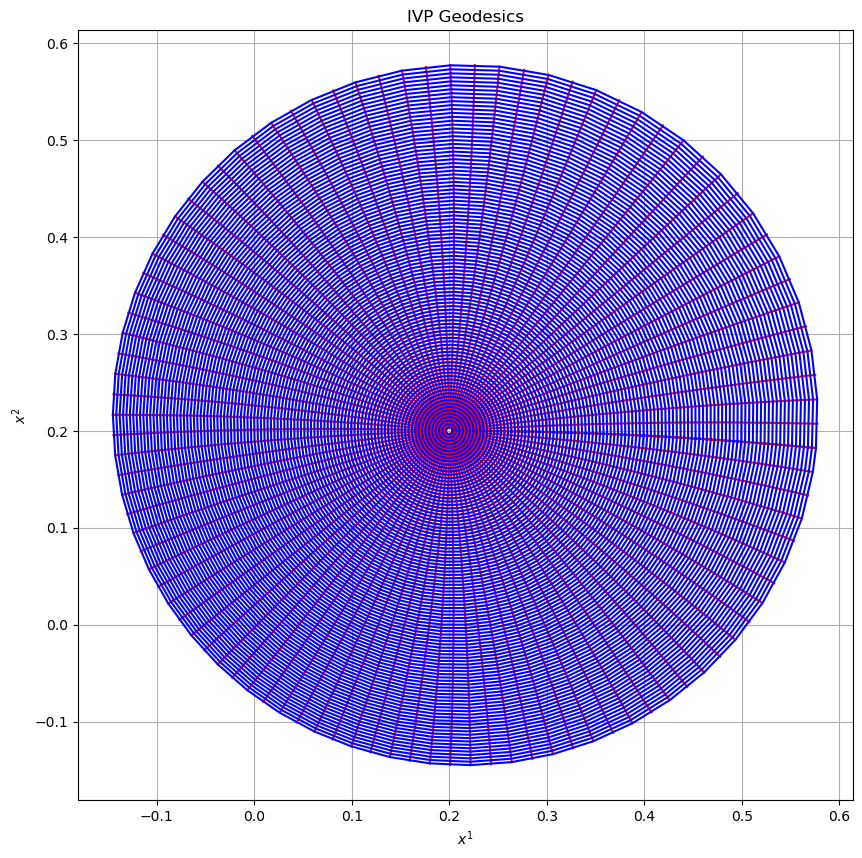

In [42]:
rm_gamma_circle = jnp.concatenate((rm_gamma, rm_gamma[0].reshape(1,rm_gamma.shape[1], rm_gamma.shape[2])))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rm_gamma[:,:,0].T, rm_gamma[:,:,1].T, color='red')
ax.plot(rm_gamma_circle[:,:,0][::2], rm_gamma_circle[:,:,1][::2], color='blue')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.grid()
fig.savefig(figure_path+'rm_ivp2d_circle.pdf', format="pdf", bbox_inches="tight")

using M.Exp for Logarithm


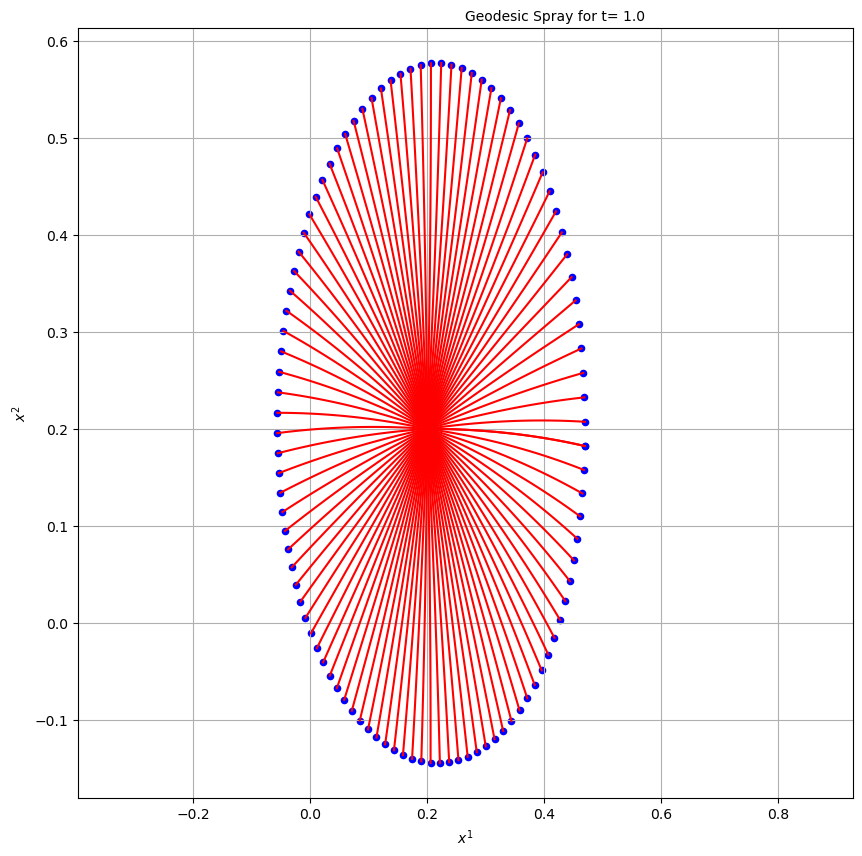

In [43]:
time_grid, rm_gamma, gamma_chart, gamma_v = vmap(lambda t: M_geodesic(t))(t_plot)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
camera = Camera(fig)# the camera gets the fig we'll plot
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.grid()
for i in range(len(t_plot)):
    ax.plot(rm_gamma[i,:,:,0].T, gamma[:,:,0,1].T, color='red')
    ax.scatter(rm_gamma[i,:,-1,0], gamma[:,-1,0,1], color='blue', s=20)
    ax.text(0.5, 1.01, "Geodesic Spray for t= "+str(t_plot[i]), transform=ax.transAxes)
    camera.snap()
animation = camera.animate() # animation ready
animation.save(figure_path+'rm_2divp.gif',
               dpi=300,
               savefig_kwargs={
                   'pad_inches': 'tight'
               }
              )
HTML(animation.to_html5_video()) # displaying the animation


using M.Exp for Logarithm


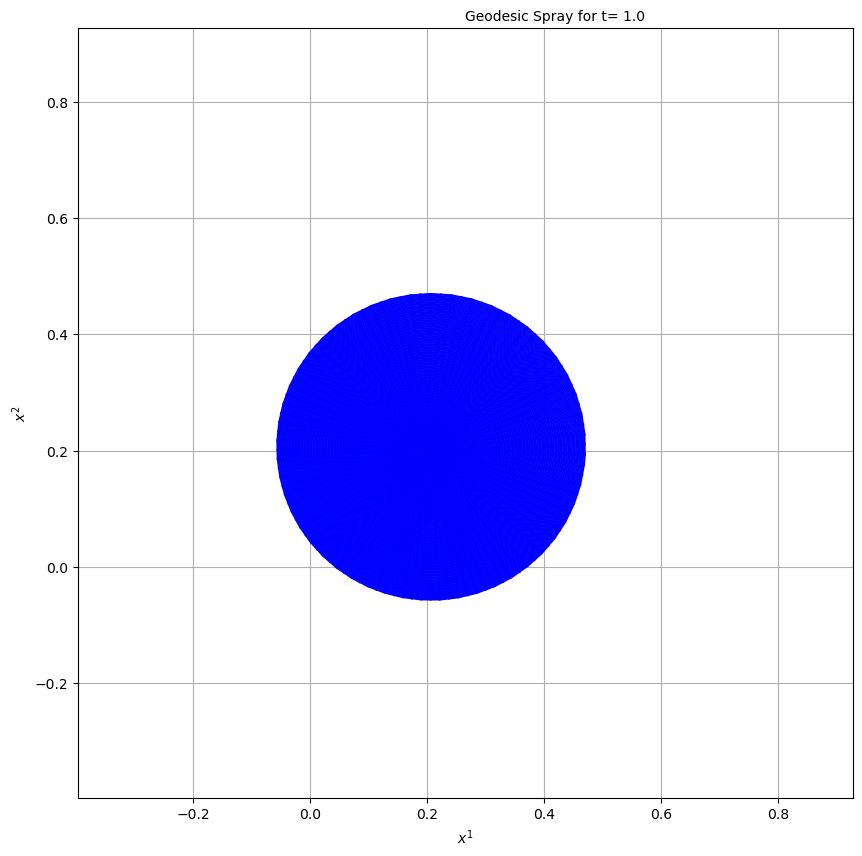

In [49]:
rm_gamma_circle = jnp.concatenate((rm_gamma, rm_gamma[:,0].reshape(rm_gamma.shape[0],1,rm_gamma.shape[2], 
                                                                   rm_gamma.shape[3])), axis=1)

time_grid, rm_gamma, gamma_chart, gamma_v = vmap(lambda t: M_geodesic(t))(t_plot)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
camera = Camera(fig)# the camera gets the fig we'll plot
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.grid()
for i in range(len(t_plot)):
    ax.plot(rm_gamma[i,:,:,0].T, rm_gamma[i,:,:,1].T, color='red')
    ax.plot(rm_gamma_circle[i,:,:,0][::2], rm_gamma_circle[i,:,:,1][::2], color='blue')
    ax.text(0.5, 1.01, "Geodesic Spray for t= "+str(t_plot[i]), transform=ax.transAxes)
    camera.snap()
animation = camera.animate() # animation ready
animation.save(figure_path+'rm_2divp.gif',
               dpi=300,
               savefig_kwargs={
                   'pad_inches': 'tight'
               }
              )
HTML(animation.to_html5_video()) # displaying the animation

### Converting Geodesics to Sphere using Steographic Projection

In [50]:
def F_steographic(x):
            
    s2 = jnp.sum(x**2)
    
    return jnp.concatenate(((1-s2).reshape(1), 2*x))/(1+s2)
                    
def invF_steographic(x):

    x0 = x[0]

    return vmap(lambda xi: xi/(1+x0))(x[1:])

In [53]:
time_grid, rm_gamma, gamma_chart, gamma_v = M_geodesic(0.0)
rm_gamma_steopgrahic = vmap(lambda x: vmap(lambda y: F_steographic(y))(x))(rm_gamma)

using M.Exp for Logarithm


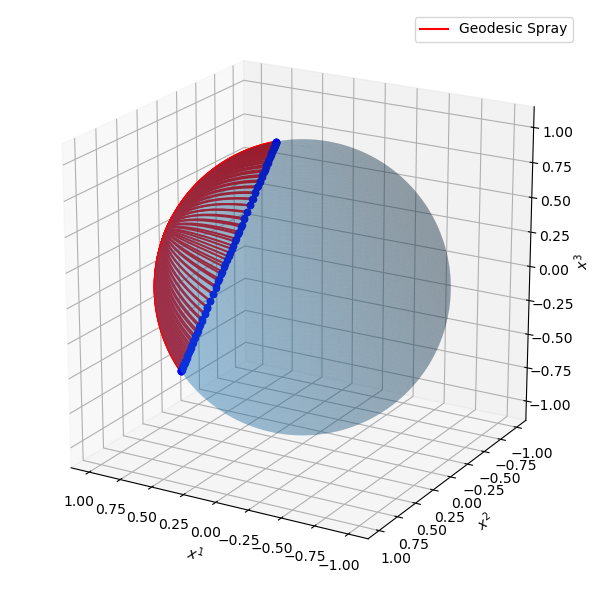

In [54]:
phi = jnp.linspace(-jnp.pi, jnp.pi, 100)
theta = jnp.linspace(-jnp.pi*0.5, jnp.pi*0.5, 100)
X1_heat = jnp.outer(jnp.cos(phi), jnp.cos(theta))
X2_heat = jnp.outer(jnp.sin(phi), jnp.cos(theta))
X3_heat = jnp.outer(jnp.ones_like(phi), jnp.sin(theta))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1_heat, X2_heat, X3_heat, rstride=1, cstride=1, alpha=0.25)

for i in range(len(rm_gamma_steopgrahic)-1):
    ax.plot(rm_gamma_steopgrahic[i][:,0], rm_gamma_steopgrahic[i][:,1], 
            rm_gamma_steopgrahic[i][:,2],color='red')
    ax.scatter(rm_gamma_steopgrahic[i][-1,0], rm_gamma_steopgrahic[i][-1,1], 
               rm_gamma_steopgrahic[i][-1,2],color='blue',
              s=20)
ax.plot(rm_gamma_steopgrahic[-1][:,0], rm_gamma_steopgrahic[-1][:,1], rm_gamma_steopgrahic[-1][:,2],
        color='red',
       label='Geodesic Spray')
ax.scatter(rm_gamma_steopgrahic[-1][-1,0], rm_gamma_steopgrahic[i][-1,1], rm_gamma_steopgrahic[-1][-1,2],
           color='blue',
              s=20)
ax.view_init(20,120)
ax.legend()
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$x^{3}$')
ax.set_xlim((-1.1, 1.1))
ax.set_ylim((-1.1, 1.1))
ax.set_zlim((-1.1, 1.1))
#ax.grid(False)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
plt.tight_layout()
ax.set_box_aspect([1,1,1]) 
fig.savefig(figure_path+'rm_ivp3d.pdf', format="pdf", bbox_inches="tight")

### Sectional Curvature

In [56]:
N_grid = 100
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda x: vmap(lambda y: M.SectionalCurvature((y,jnp.zeros(1)), e1, e2))(x))(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


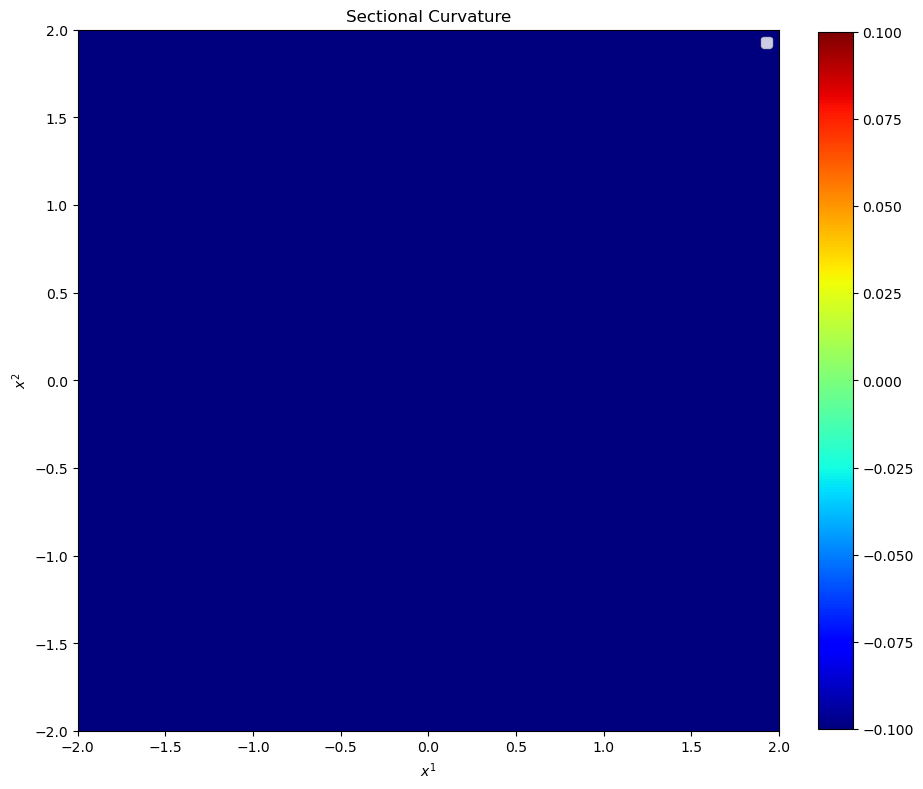

In [66]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()

fig.savefig(figure_path+'rm_curvature.pdf', format="pdf", bbox_inches="tight")

## Stochastic Pertubations

In [14]:
N_sim = 100
key = jran.PRNGKey(2712)
eps = jran.normal(key, shape=(N_sim, 3))

In [15]:
eps.shape

(100, 3)

### Indicatrices 

In [35]:
def indicatrix(t, x, eps=jnp.zeros(3), N=100):
    
    x = (x, jnp.zeros(len(x)))
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = mua_fun(t,x)+sigmaa_fun(t,x)*eps[0]
    b = mub_fun(t,x)+sigmab_fun(t,x)*eps[1]
    theta = mutheta_fun(t,x)+sigmatheta_fun(t,x)*eps[2]
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0][0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[0][1]
    
    return x1, x2

q1, q2 = vmap(lambda e: vmap(lambda y: vmap(lambda x: indicatrix(0.5, x, e))(y))(X_plot))(eps)

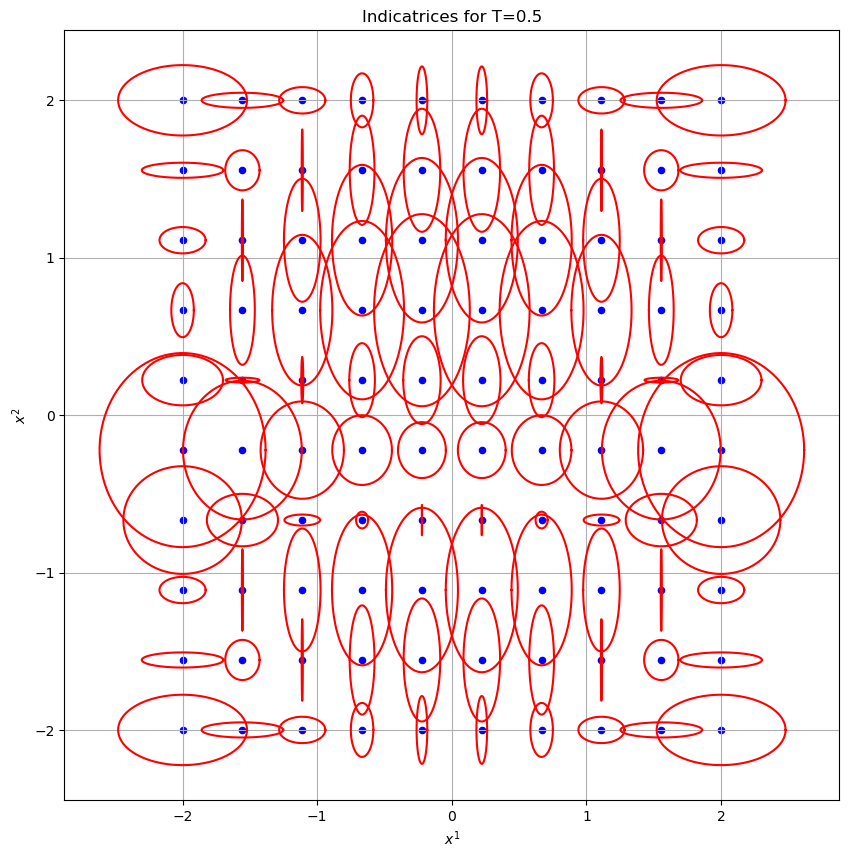

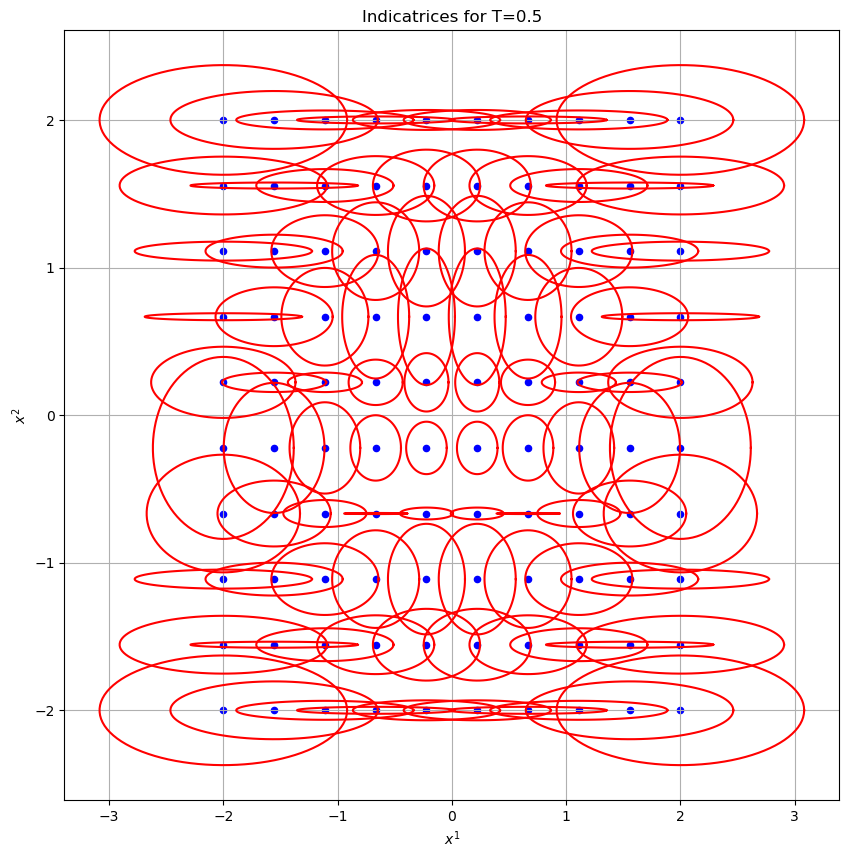

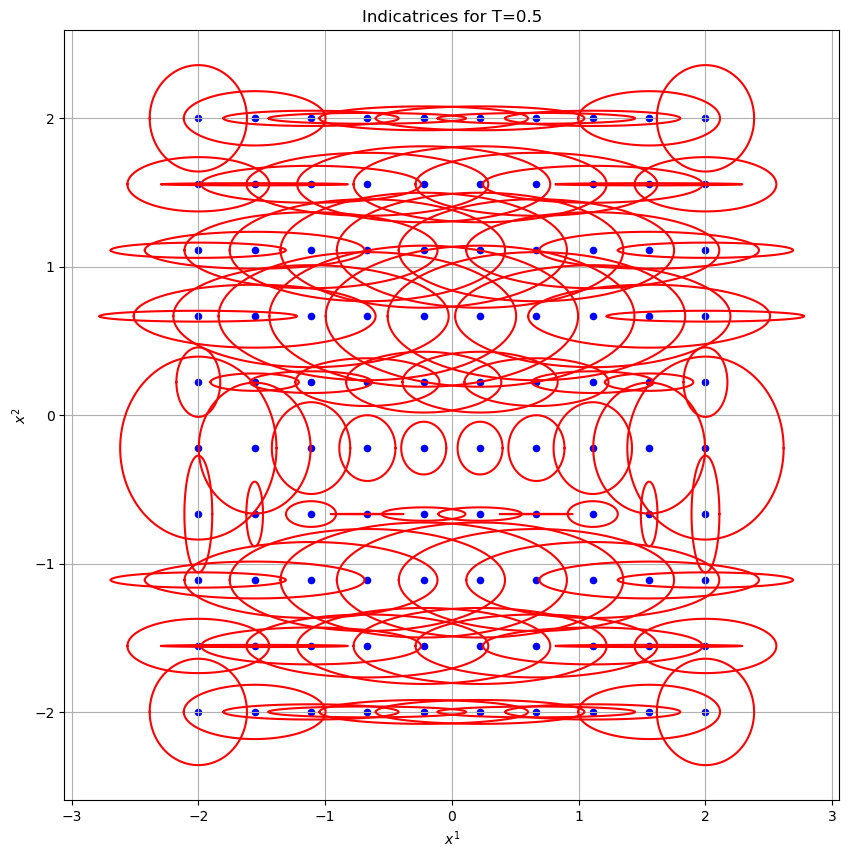

In [36]:
for k in range(3):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for i in range(N_plot):
        for j in range(N_plot):
            ax.plot(q1[k,i,j,:], q2[k,i,j,:], color='red')
            ax.scatter(X_plot[i,j,0], X_plot[i,j,1], color='blue', s=20)

    ax.set_xlabel("$x^{1}$")
    ax.set_ylabel("$x^{2}$")
    ax.set_title("Indicatrices for T=0.5")
    ax.grid()

plt.show()
fig.savefig(figure_path+'rm_indicatrix.pdf', format="pdf", bbox_inches="tight")

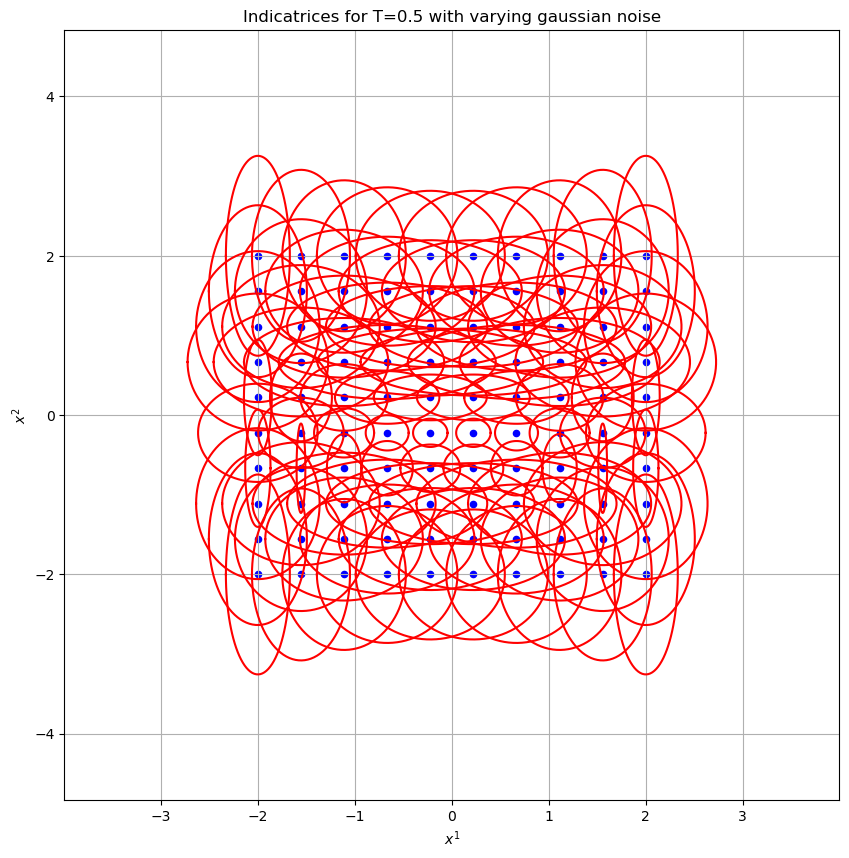

In [37]:
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
#heatmap = sec[:,50,:]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
camera = Camera(fig)# the camera gets the fig we'll plot
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices for T=0.5 with varying gaussian noise")
ax.grid()
for k in range(len(eps[:10])):
    for i in range(N_plot):
        for j in range(N_plot):
            ax.plot(q1[k,i,j,:], q2[k,i,j,:], color='red')
            ax.scatter(X_plot[i,j,0], X_plot[i,j,1], color='blue', s=20)

    #fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)
    
    camera.snap()
animation = camera.animate() # animation ready
animation.save(figure_path+'rm_indicatrix.gif',
               dpi=300,
               savefig_kwargs={
                   'pad_inches': 'tight'
               }
              )
HTML(animation.to_html5_video()) # displaying the animation

    #plt.show()
    #fig.savefig(figure_path+'volume'+str(t_val[i]).replace('.','_')+'.pdf', format="pdf", bbox_inches="tight")

### Computing the Metric

In [38]:
def volume_measure(t, x, eps):
    
    M = RiemannIndicatrix(mua_fun=lambda x: mua_fun(t,x),
                        mub_fun=lambda x: mub_fun(t,x),
                   mutheta_fun=lambda x: mutheta_fun(t,x),
                   eps=eps,
                   sigmaa_fun=lambda x: sigmaa_fun(t,x),
                   sigmab_fun=lambda x: sigmab_fun(t,x),
                   sigmatheta_fun=lambda x: sigmatheta_fun(t,x))
    
    return jnp.sqrt(jnp.linalg.det(M.g((x, jnp.zeros(1)))))

g = vmap(lambda e: vmap(lambda y: vmap(lambda x: volume_measure(0.5,x,e))(y))(X_grid))(eps)

using M.Exp for Logarithm


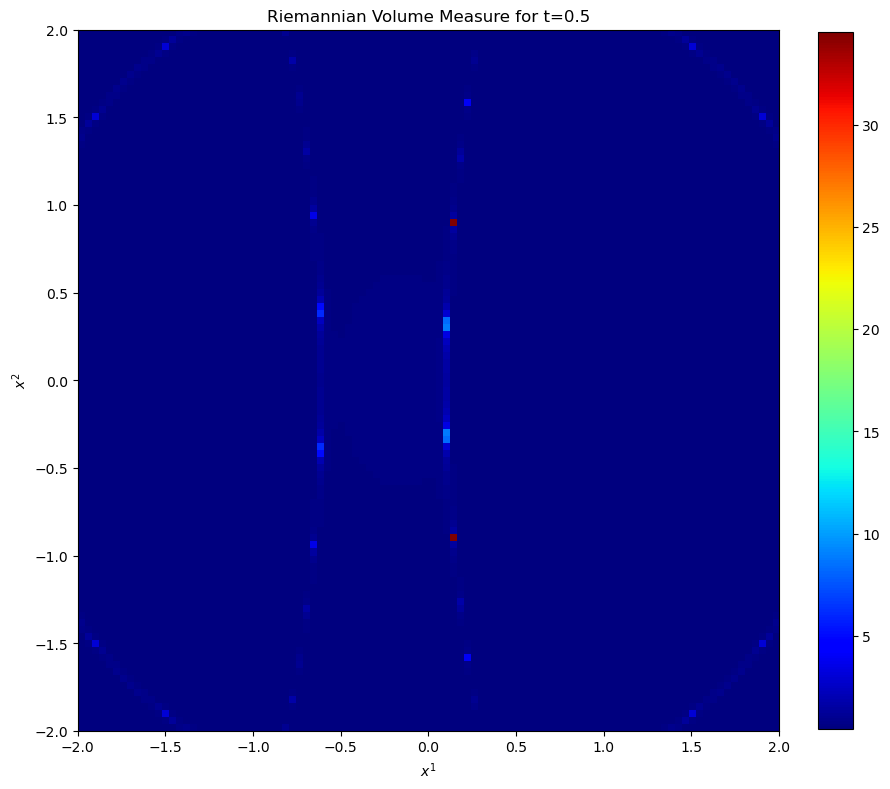

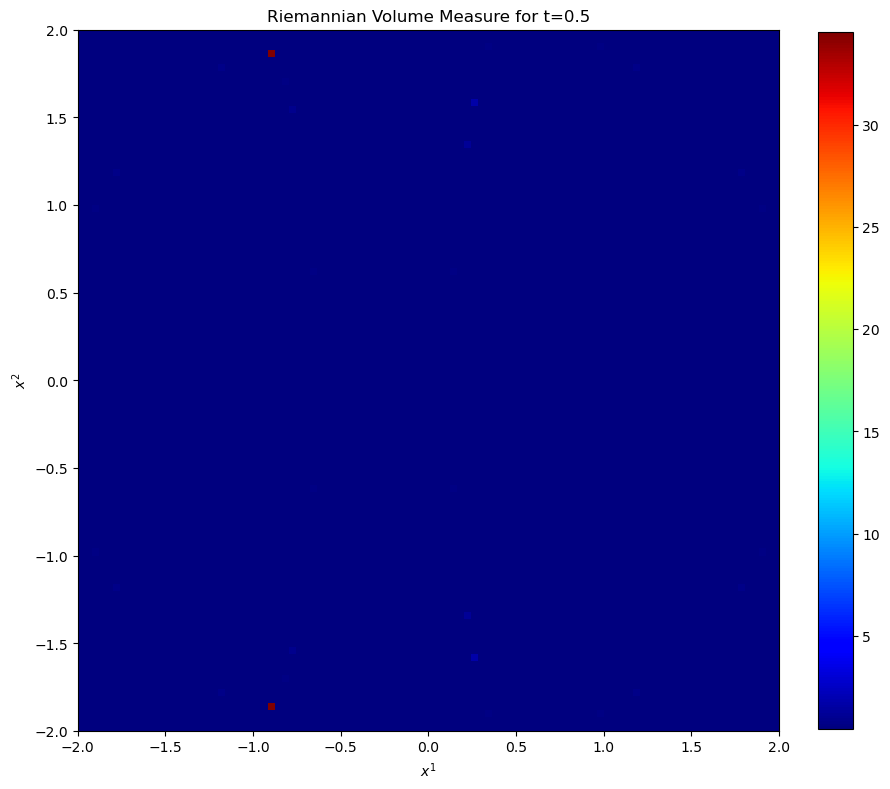

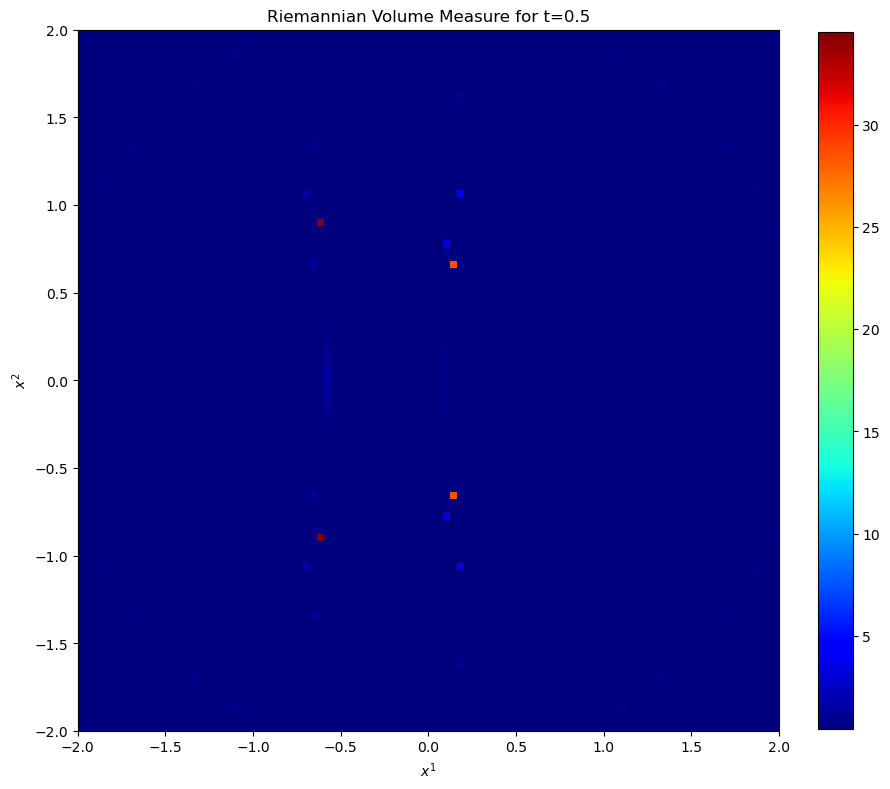

In [39]:
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
#heatmap = sec[:,50,:]

for k in range(3):
    extent = [start, end, start, end]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(g[k].T, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_xlim([start, end])
    ax.set_ylim([start, end])
    ax.set_title("Riemannian Volume Measure for t=0.5")
    ax.set_xlabel(r'$x^{1}$')
    ax.set_ylabel(r'$x^{2}$')
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
    m.set_array(g[i])
    fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

    plt.show()
    fig.savefig(figure_path+'rm_volume.pdf', format="pdf", bbox_inches="tight")

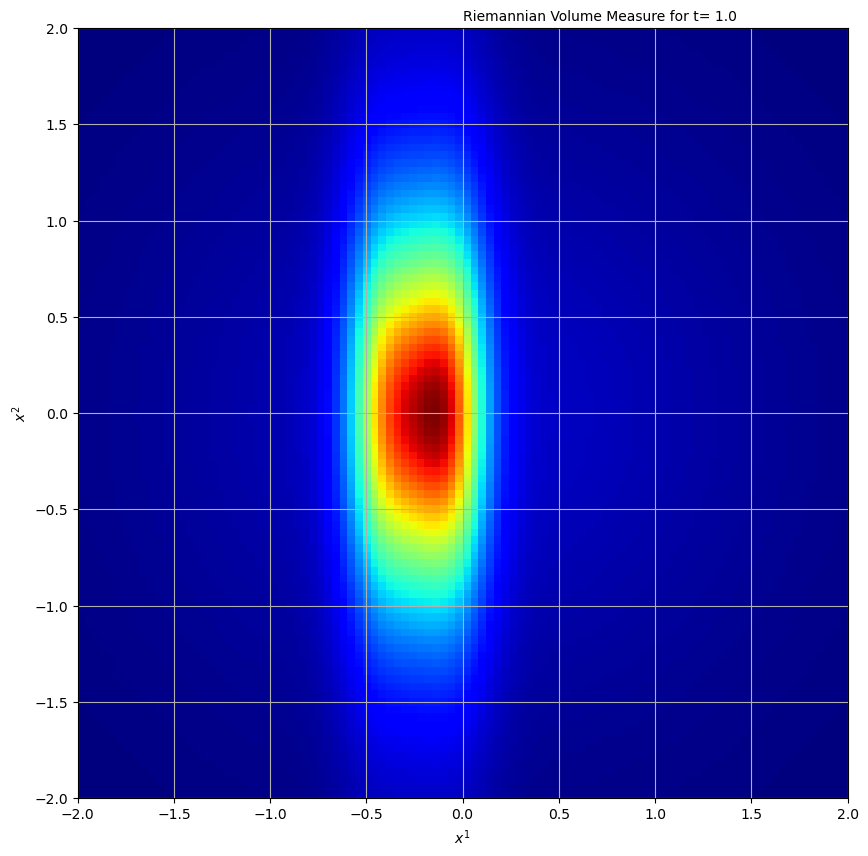

In [40]:
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
#heatmap = sec[:,50,:]
extent = [start, end, start, end]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
camera = Camera(fig)# the camera gets the fig we'll plot
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.grid()
for i in range(len(eps[:10])):
    ax.imshow(g[i].T, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_xlim([start, end])
    ax.set_ylim([start, end])
    ax.set_xlabel(r'$x^{1}$')
    ax.set_ylabel(r'$x^{2}$')
    ax.text(0.5, 1.01, "Riemannian Volume Measure for t= "+str(t_plot[i]), transform=ax.transAxes)
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
    m.set_array(g[i])
    #fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)
    
    camera.snap()
animation = camera.animate() # animation ready
animation.save(figure_path+'rm_volume.gif',
               dpi=300,
               savefig_kwargs={
                   'pad_inches': 'tight'
               }
              )
HTML(animation.to_html5_video()) # displaying the animation

    #plt.show()
    #fig.savefig(figure_path+'volume'+str(t_val[i]).replace('.','_')+'.pdf', format="pdf", bbox_inches="tight")

### Sectional Curvature

In [50]:
def sec_curvature(t,eps):
    
    M = RiemannIndicatrix(mua_fun=lambda x: mua_fun(t,x),
                        mub_fun=lambda x: mub_fun(t,x),
                   mutheta_fun=lambda x: mutheta_fun(t,x),
                   eps=eps,
                   sigmaa_fun=lambda x: sigmaa_fun(t,x),
                   sigmab_fun=lambda x: sigmab_fun(t,x),
                   sigmatheta_fun=lambda x: sigmatheta_fun(t,x))
    
    return vmap(lambda x: vmap(lambda y: M.SectionalCurvature((y,jnp.zeros(1)), e1, e2))(x))(X)

N_grid = 100
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda e: sec_curvature(0.5, e))(eps)

using M.Exp for Logarithm


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


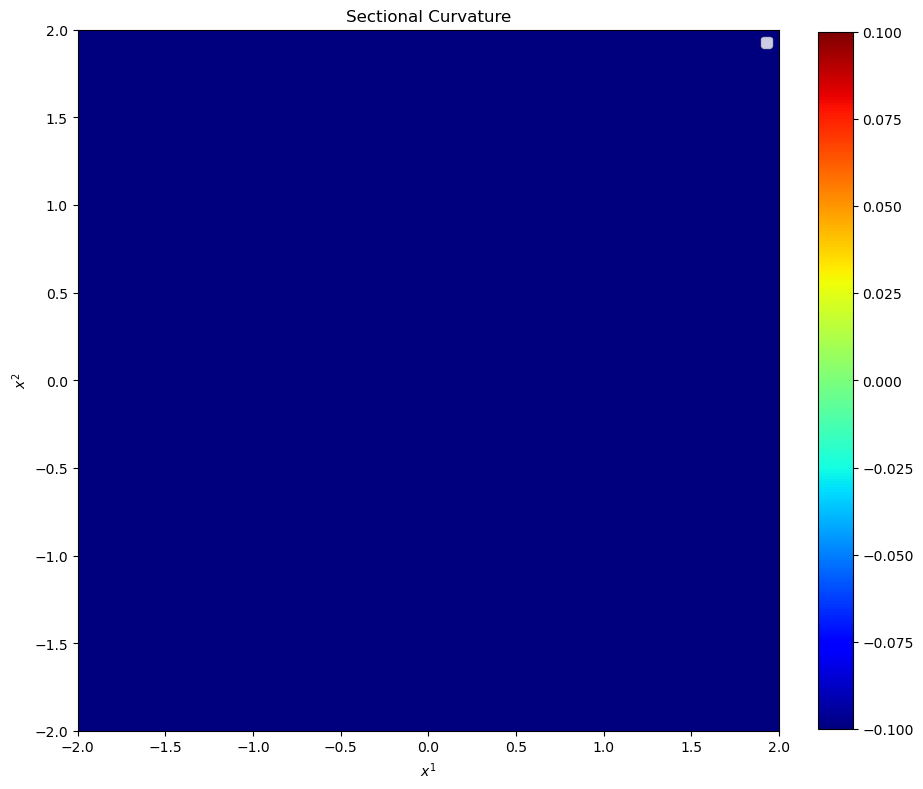

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


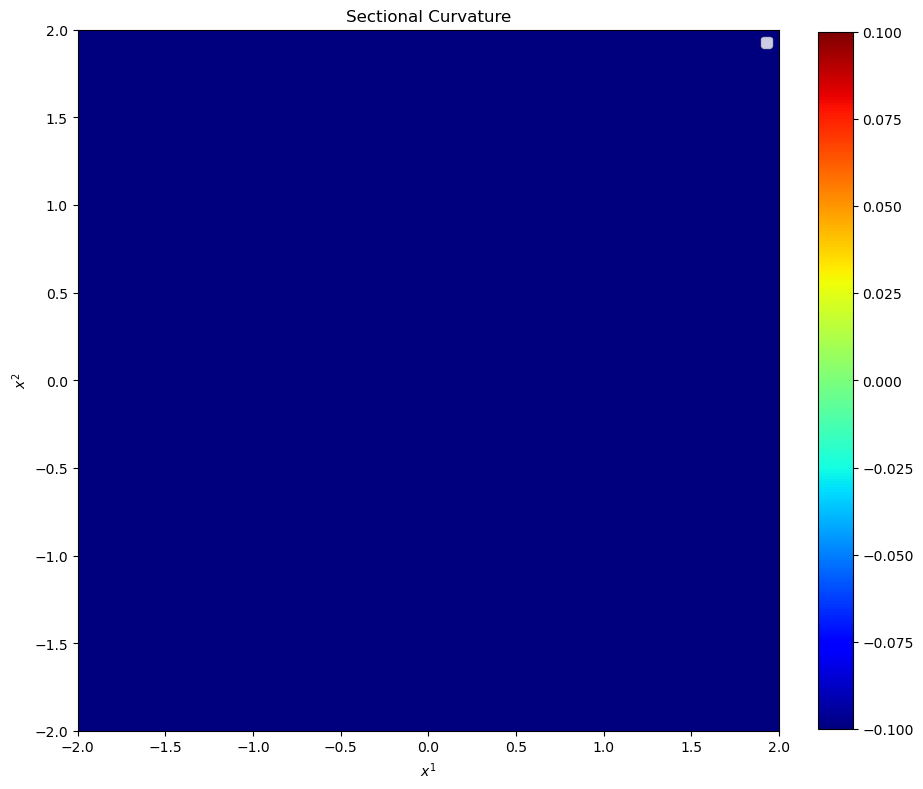

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


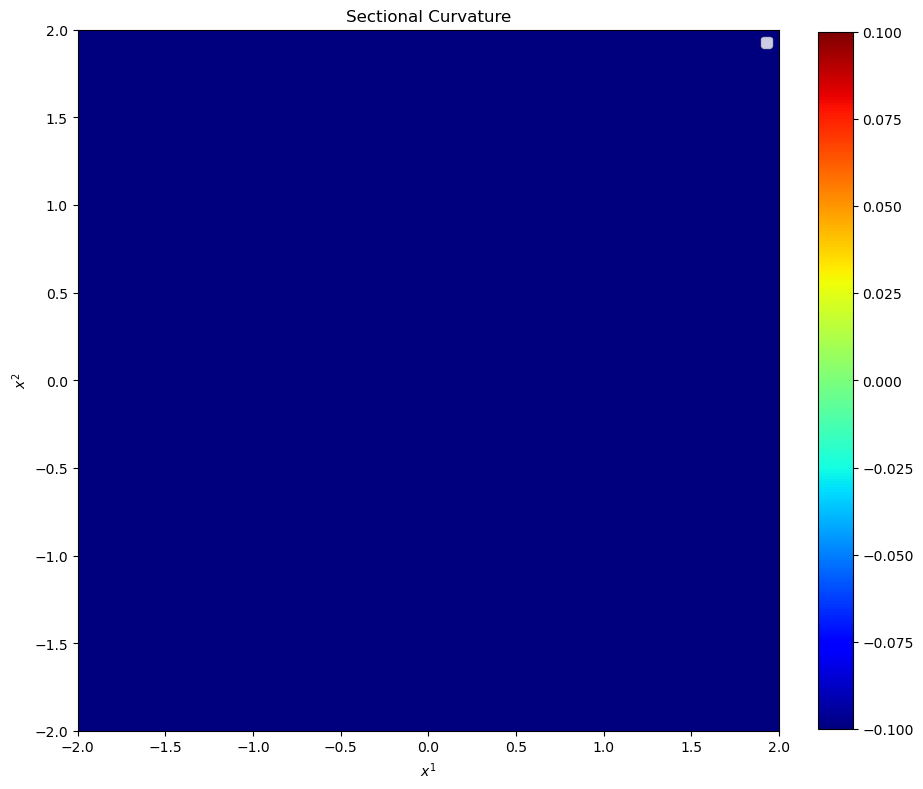

In [51]:
for k in range(3):    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    #heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
    #heatmap = gaussian_filter(sec, sigma=1.0)
    #heatmap /= jnp.linalg.norm(heatmap)
    heatmap = sec[k]
    extent = [-2.0, 2.0, -2.0, 2.0]
    ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
    ax.set_xlim([-2.0, 2.0])
    ax.set_ylim([-2.0, 2.0])
    ax.set_title("Sectional Curvature")
    ax.set_xlabel("$x^{1}$")
    ax.set_ylabel("$x^{2}$")
    ax.legend()
    m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
    m.set_array(heatmap)
    fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

    plt.show()

    fig.savefig(figure_path+'rm_curvature.pdf', format="pdf", bbox_inches="tight")